In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import itertools as it

## The Plan:
- Generate random graphs, with each node containing a tf constant (risk) and variable (allocated resources)
- Run a simple optimization to allocate resources according to risk, where cost is risk\*resources for each node
- Run more complex optimization where cost is (risk + lambda\*sum(neighbor_risk))\*resources. This will simulate a more realistic graph query with more useful output. Intuitively, you may want to allocate more resources to entities that are also associated with risky entities


In [2]:
# create new session if we need it
sess = tf.Session()

Node 0 | Risk of the node: 0.0712998
Node 1 | Risk of the node: 0.744463
Node 2 | Risk of the node: 0.247937
Node 3 | Risk of the node: 0.0831013
Node 4 | Risk of the node: 0.976333


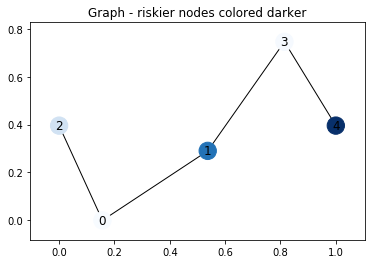

In [5]:
# generate a simple but nontrivial random graph
n = 5
dup_edge_p = 0.3

# Modelling the resource allocation with Normal Distrib - mean: m, and stddev = s
m = 20
s = 0.25

sess.run(tf.global_variables_initializer())
G_rand = nx.duplication_divergence_graph(n, dup_edge_p, 1)

# add tf risk constants and variables to each node
for node, data in G_rand.nodes_iter(data=True):
    data['risk'] = tf.constant(np.random.uniform(0,1))
    data['allocation'] = tf.Variable(tf.random_normal([1,1], mean = m, stddev=s))
    
# show what we generated
for node, data in it.islice(G_rand.nodes_iter(data=True),5):
    print 'Node',node,'|', 'Risk of the node:', sess.run(data['risk'])
    #print 'Node data:', data
    #print 'Allocation (Variable of the node):', sess.run(data['allocation'])

color_values = [sess.run(data['risk']) for node, data in G_rand.nodes_iter(data=True)]

pos = nx.spring_layout(G_rand)
nx.draw_networkx_nodes(G_rand, pos, cmap=plt.cm.Blues, node_color = color_values)
nx.draw_networkx_edges(G_rand, pos, arrows=True)
nx.draw_networkx_labels(G_rand,pos)
plt.title('Graph - riskier nodes colored darker')
plt.show()

In [6]:
# first query, just sum risk/allocation and l2 norm

#def query_risk(G):
    
    # Function that should reduce the risk of 

def query1(G, alpha=tf.constant(0.0)):
    
    #query1 returns the 'Cost = Sum over all nodes (Risk of a node * Resources of a node)
    
    allocation_sumexp = tf.constant(0.0)
    risk_sum = tf.constant(0.0)
    
    for node, data in G.nodes_iter(data=True):
        allocation_sumexp += tf.exp(data['allocation'])
        risk_sum += data['risk']
    
    return_value = tf.constant(0.0)
    
    for i in nx.dfs_preorder_nodes(G, 0):
        node = G.node[i]
        softmax_allocation = tf.exp(node['allocation'])/allocation_sumexp
        normalized_risk = tf.exp(node['risk'])/risk_sum
        node['softmax_allocation'] = softmax_allocation
        #return_value += return_value + (normalized_risk/softmax_allocation) + alpha*node['allocation']**2
        return_value += (normalized_risk/softmax_allocation) + alpha*node['softmax_allocation']**2 
        
#         return_value += return_value + tf.constant(2.0)*(tf.log(normalized_risk) - node['allocation'] 
#                                                          + tf.log(allocation_sumexp))
#         return_value += return_value - tf.constant(0.5)*(tf.log(normalized_risk)) \
#                                      - tf.constant(0.4)*(tf.log(softmax_allocation) - tf.log(allocation_sumexp))
    return return_value

(0, 22.655647)
(10, 18.684774)
(20, 18.685585)
(30, 18.685032)
(40, 18.683804)
(50, 18.682894)
(60, 18.682428)
(70, 18.68223)
(80, 18.682148)
(90, 18.682114)

node  0 risk 0.0712998 softmax allocation 0.164775
node  1 risk 0.744463 softmax allocation 0.230867
node  2 risk 0.247937 softmax allocation 0.179914
node  3 risk 0.0831013 softmax allocation 0.165748
node  4 risk 0.976333 softmax allocation 0.258696


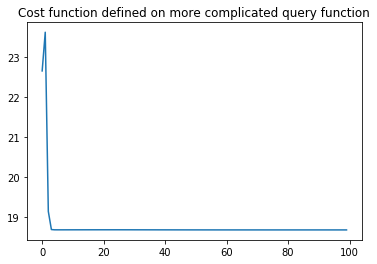

In [7]:
def test1():
    learning_rate = 1.0
    alpha = tf.constant(0.2)
    cost = query1(G_rand, alpha)
    optimizer = tf.train.AdagradOptimizer(learning_rate)
    train = optimizer.minimize(cost)
    #reinitialise everything
    sess.run(tf.global_variables_initializer())
    #Now optimize with this form
    train_steps=100
    cost_tracker = np.zeros([train_steps])
    for step in range(train_steps):
        sess.run(train)
        if step%10==0:
            print(step, sess.run(cost)[0][0])
        cost_tracker[step] = sess.run(cost)
    plt.plot(cost_tracker)
    plt.title("Cost function defined on more complicated query function")
    
    print 
    for node, data in G_rand.nodes_iter(data=True):
        print 'node ',node, 'risk', sess.run(data['risk']),'softmax allocation', sess.run(data['softmax_allocation'][0][0])
              #'allocation', sess.run(data['allocation']),\
              
    
test1()

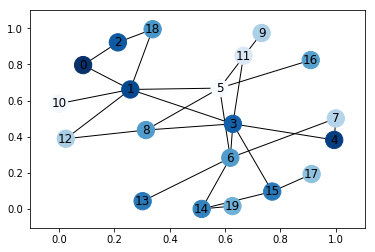

In [57]:
pos = nx.spring_layout(G_rand)
nx.draw_networkx_nodes(G_rand, pos, cmap=plt.cm.Blues, node_color = color_values)
nx.draw_networkx_edges(G_rand, pos, arrows=True)
nx.draw_networkx_labels(G_rand,pos)
plt.show()

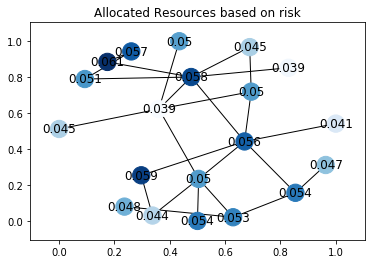

In [58]:
# Setting node attribute (Softmax) values 

softmax_attrib = {}

for node, data in G_rand.nodes_iter(data=True):
        softmax_attrib[node] = round(sess.run(data['softmax_allocation'])[0][0],3)

# Printing the graph below

pos = nx.spring_layout(G_rand)
nx.draw_networkx_nodes(G_rand, pos, cmap=plt.cm.Blues, node_color = color_values)
nx.draw_networkx_edges(G_rand, pos, arrows=True)
#nx.draw_networkx_labels(G_rand,pos)
nx.draw_networkx_labels(G_rand,pos,softmax_attrib)
plt.title('Allocated Resources based on risk')
plt.show()

In [3]:
#(1)------ Generating huge dataset (10K nodes)

# generate a simple but nontrivial random graph
n = 1000
dup_edge_p = 0.3

# Modelling the resource allocation with Normal Distrib - mean: m, and stddev = s
m = 20
s = 0.25

sess.run(tf.global_variables_initializer())
G_rand_huge = nx.duplication_divergence_graph(n, dup_edge_p, 1)

Node 0 | Risk of the node: 0.0376423
Node 1 | Risk of the node: 0.910626
Node 2 | Risk of the node: 0.846125
Node 3 | Risk of the node: 0.763212
Node 4 | Risk of the node: 0.267909


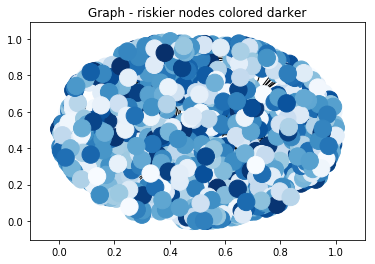

In [4]:
# add tf risk constants and variables to each node
for node, data in G_rand_huge.nodes_iter(data=True):
    data['risk'] = tf.constant(np.random.uniform(0,1))
    data['allocation'] = tf.Variable(tf.random_normal([1,1], mean = m, stddev=s))
    
# show what we generated
for node, data in it.islice(G_rand_huge.nodes_iter(data=True),5):
    print 'Node',node,'|', 'Risk of the node:', sess.run(data['risk'])
    #print 'Node data:', data
    #print 'Allocation (Variable of the node):', sess.run(data['allocation'])

color_values = [sess.run(data['risk']) for node, data in G_rand_huge.nodes_iter(data=True)]

pos = nx.spring_layout(G_rand_huge)
nx.draw_networkx_nodes(G_rand_huge, pos, cmap=plt.cm.Blues, node_color = color_values)
nx.draw_networkx_edges(G_rand_huge, pos, arrows=True)
#nx.draw_networkx_labels(G_rand_huge,pos)
plt.title('Graph - riskier nodes colored darker')
plt.show()
fig = plt.figure()
fig.savefig('Large-graph-generated.png', dpi=fig.dpi)

# ------- Requires printing and saving

In [59]:
#(2)------ Area for computing Computational Graph Query (Abstract - applicable to multiple graphs)
# Chaining Queries / Gremlin like structure

''' Input to this cell would include a set of nodes and edges some of which will be zero and non-zero'''

' Input to this cell would include a set of nodes and edges some of which will be zero and non-zero'

In [ ]:
# Query 1 - Gabe's Query

In [ ]:
# Query 2 -  Financial Risk Allocation
# Code similar to code above just allocating 1-whatever